In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

from dask.diagnostics import ProgressBar
from util import *

from parallel import DataParallelCriterion

In [2]:
np.__version__, pd.__version__, cv2.__version__, rdkit.__version__, torch.__version__

('1.19.5', '1.2.5', '4.5.3', '2021.03.5', '1.7.1+cu110')

In [3]:
train = pd.read_csv(join(PATH.INPUT, 'train.csv'))
dev   = pd.read_csv(join(PATH.INPUT, 'dev.csv'))
test  = pd.read_csv(join(PATH.INPUT, 'test.csv'))

In [4]:
train.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-c4cc(Cl)ccc4O)c3C)cc2)cc1,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


In [5]:
test.head()

,uid,SMILES
0,test_0,COc1ccc(S(=O)(=O)NC2CCN(C3CCCCC3)CC2)c(C)c1C
1,test_1,CC(CCCC1CCC2C3=C(CC[C@]12C)[C@@]1(C)CC[C@H](C)C(C)(C)[C@@H]1CC3)C(C)(C)O
2,test_2,C[C@@H]1C[C@@H]1c1ccc2c(c1)c(-c1ccc[nH]c1=O)c(C(=O)NS(C)(=O)=O)n2Cc1ccc(F)cc1F
3,test_3,CCCn1c(=O)c2ccccc2n2c(SCC(=O)NC(Cc3ccccc3)c3ccccc3)nnc12
4,test_4,CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)S(=O)(=O)c1ccc2nc(N)sc2c1


In [6]:
train = pd.concat([train, dev])

In [7]:
len(train)

30345

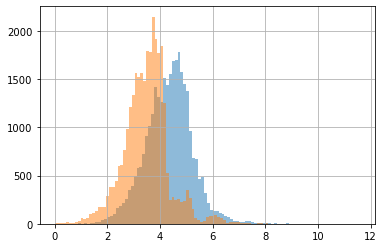

In [8]:
train['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train['T1_energy(eV)'].hist(bins=100, alpha=0.5);

In [9]:
@delayed
def save_img(row):
    file   = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m is not None:
        img = Draw.MolToImage(m, size=(300, 300))
        img.save(join(PATH.INPUT, 'train_img', f'{file}.png'))

os.makedirs(join(PATH.INPUT, 'train_img'), exist_ok=True)
if not exists(join(PATH.INPUT, 'train_img')):
    tasks = [save_img(row) for _, row in train.iterrows()]
    with ProgressBar():
        compute(*tasks, scheduler='processes')

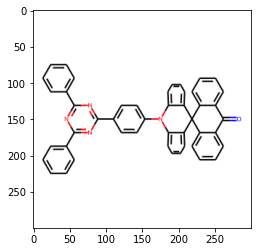

In [10]:
sample_img = cv2.imread(join(PATH.INPUT, 'train_img', 'dev_0.png'))
plt.imshow(sample_img);

# 하이퍼파라미터 

In [11]:
PATH.MODEL = join(PATH.ROOT, 'model')
os.makedirs(PATH.MODEL, exist_ok=True)

multi_gpu = True
device = torch.device('cuda:0')  # TODO: fix (use device?)
BATCH_SIZE = 64
EPOCHS = 10
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
learning_rate = 1e-4
vision_pretrain = True
save_path = f"join(PATH.MODEL, 'best_model.pt')"

# SMILES Tokenizing

In [12]:
class SMILES_Tokenizer:
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()  # unique atom, connection, ...
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unioque_char = sorted(unique_char)
        for i, char in enumerate(unique_char):
            self.txt2idx[char] = i+2  # [2, 3, ...]
            self.idx2txt[i+2]  = char # ['C', 'H', ...]
        
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:  # ??
                    seq[i] = 1
            seqs.append(seq)
        return np.array(seqs)

In [13]:
max_len = train.SMILES.str.len().max()  # max length of SMILES

In [14]:
tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train.SMILES)

In [15]:
seqs = tokenizer.txt2seq(train.SMILES)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()
imgs = (join(PATH.INPUT, 'train_img') + '/' + train.uid + '.png').to_numpy()

100%|██████████| 30345/30345 [00:00<00:00, 105390.28it/s]


# 학습 데이터셋

In [16]:
from sklearn.utils import shuffle
imgs, seqs, labels = shuffle(imgs, seqs, labels, random_state=42)

In [17]:
N_TRAIN = 27000
train_imgs = imgs[:N_TRAIN]
train_seqs = seqs[:N_TRAIN]
train_labels = labels[:N_TRAIN]
val_imgs = imgs[N_TRAIN:]
val_seqs = seqs[N_TRAIN:]
val_labels = labels[N_TRAIN:]

In [18]:
train_imgs.shape, train_seqs.shape, train_labels.shape, val_imgs.shape, val_seqs.shape, val_labels.shape

((27000,), (27000, 265), (27000, 2), (3345,), (3345, 265), (3345, 2))

In [19]:
class CustomDataset(Dataset):
    def __init__(self, imgs, seqs, labels=None, mode='train'):
        self.mode = mode
        self.imgs = imgs
        self.seqs = seqs
        if self.mode == 'train':
            self.labels = labels
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, i):
        img = cv2.imread(self.imgs[i]).astype(np.float32) / 255
        img = np.transpose(img, (2,0,1))  # [channel, height, width]
        if self.mode == 'train':
            return {
                'img': torch.tensor(img, dtype=torch.float32),
                'seq': torch.tensor(self.seqs[i], dtype=torch.long),
                'label': torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return {
                'img': torch.tensor(img, dtype=torch.float32),
                'seq': torch.tensor(self.seqs[i], dtype=torch.long)
            }

In [20]:
train_dataset = CustomDataset(train_imgs, train_seqs, train_labels)
val_dataset   = CustomDataset(val_imgs, val_seqs, val_labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, shuffle=True)

In [21]:
sample_batch = next(iter(train_dataloader))

In [22]:
print(sample_batch['img'].size(), sample_batch['seq'].size(), sample_batch['label'].size())
print(sample_batch['img'].dtype, sample_batch['seq'].dtype, sample_batch['label'].dtype)

torch.Size([64, 3, 300, 300]) torch.Size([64, 265]) torch.Size([64, 2])
torch.float32 torch.int64 torch.float32


In [23]:
class CNN_Encoder(nn.Module):
    def __init__(self, embedding_dim, rate):
        super().__init__()
        model = models.resnet50(pretrained=vision_pretrain)
        modules = list(model.children())[:-2]
        self.feature_extract_model = nn.Sequential(*modules)
        self.dropout1 = nn.Dropout(rate)
        self.fc = nn.Linear(2048, embedding_dim)
        self.dropout2 = nn.Dropout(rate)
        
    def forward(self, x):
        x = self.feature_extract_model(x)
        x = x.permute(0, 2, 3, 1)
        x = x.view(x.size(0), -1, x.size(3))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc(x))
        x = self.dropout2(x)
        return x
    
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_layers, rate):
        super().__init__()
        self.embedding = nn.Embedding(max_len, embedding_dim)
        self.dropout = nn.Dropout(rate)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, num_layers)
        self.final_layer = nn.Linear((max_len+100)*embedding_dim, 2)
    
    def forward(self, enc_out, dec_inp):
        embedded = self.embedding(dec_inp)
        embedded = self.dropout(embedded)
        embedded = torch.cat([enc_out, embedded], dim=1)
        hidden, _ = self.lstm(embedded)
        hidden = hidden.view(hidden.size(0), -1)
        output = nn.ReLU()(self.final_layer(hidden))
        return output
    
class CNN2RNN(nn.Module):
    def __init__(self, embedding_dim, max_len, num_layers, rate):
        super().__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_layers, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        return output

In [24]:
model = CNN2RNN(embedding_dim=embedding_dim, max_len=max_len, num_layers=num_layers, rate=dropout_rate)
if multi_gpu:
    model = nn.DataParallel(model)
    model.cuda()
else:
    model = model.to(device)

# 학습 정의

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if multi_gpu:  # TOOD: fix
#     criterion = DataParallelCriterion(criterion)    
    criterion = nn.L1Loss()
else:
    criterion = nn.L1Loss()

In [26]:
def train_step(batch_item, epoch, batch, training):
    ### TODO: fix (use device?)
    img = batch_item['img'].to(device)
    seq = batch_item['seq'].to(device)
    label = batch_item['label'].to(device)
    
    if training:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, seq)
            loss   = criterion(output, label)
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, seq)
            loss   = criterion(output, label)
    return loss

# 학습 

In [28]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': f'{batch_loss.item():06f}',
            'Total Loss': f'{total_loss/(batch+1):06f}'
        })
    loss_plot.append(total_loss/(batch+1))  # mean loss
      
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training=False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': f"{batch_loss.item():06f}",
            'Total Val Loss': f"{total_val_loss/(batch+1)}"
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

422it [01:13,  5.73it/s, Epoch=1, Loss=0.371849, Total Loss=0.509192]
0it [00:00, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/modules/rnn.py:581: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
53it [00:04, 10.78it/s, Epoch=1, Val Loss=0.423408, Total Val Loss=0.37218573689460754]
422it [01:08,  6.13it/s, Epoch=2, Loss=0.359024, Total Loss=0.330480]
53it [00:04, 10.77it/s, Epoch=2, Val Loss=0.278252, Total Val Loss=0.3255631923675537] 
422it [01:08,  6.18it/s, Epoch=3, Loss=0.281840, Total Loss=0.288206]
53it [00:04, 10.69it/s, Epoch=3, Val Loss=0.232291, Total Val Loss=0.2943139374256134] 
422it [01:08,  6.19it/s, Epoch=4, Loss=0.296

# 학습 결과

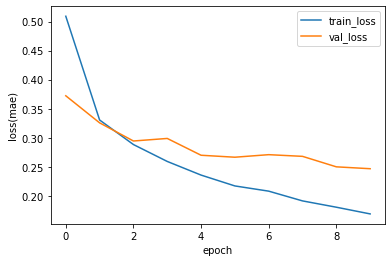

In [29]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

# 모델 복원

In [27]:
model = torch.load(save_path)

FileNotFoundError: [Errno 2] No such file or directory: "join(PATH.MODEL, 'best_model.pt')"

# 테스트 데이터 및 제출 양식 로드

In [ ]:
test = pd.read_csv(join(PATH.INPUT, 'test.csv'))
submission = pd.read_csv(join(PATH.OUTPUT, 'sample_submission.csv'))

# 테스트 데이터 전처리

In [ ]:
os.makedirs(join(PATH.INPUT, 'test_img'), exist_ok=True)
for idx, row in tqdm(test.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m is not None:
        img = Draw.MolToImage(m, size=(300, 300))
        img.save(join(PATH.INPUT, 'test_img', f"{file}.png"))

# 테스트 데이터셋

In [ ]:
test_seqs = tokenizer.txt2seq(test.SMILES)
test_imgs = (join(PATH.INPUT, 'test_img') + '/' + test.uid + '.png').to_numpy()

In [ ]:
test_dataset = CustomDataset(imgs=test_imgs, seqs=test_seqs, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=16)

# 추론 및 제출 

In [ ]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['seq'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = output.cpu().numpy()
        gap = output[:, 0] - output[:, 1]
        gap = np.where(gap < 0, -gap, gap)
        result.extend(list(gap))
    return result

In [ ]:
pred = predict(test_dataloader)

In [ ]:
submission['ST1_GAP(eV)'] = pred

In [ ]:
submission.to_csv(join(PATH.OUTPUT, 'baseline.csv'), index=False)

In [ ]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
    join(PATH.OUTPUT, 'baseline.csv'),
    '542784023fe8a00bb17969fc1a171bc63699fd3ef71c94ecac9a81b3001080d3',
    '235789',
    'Torch',
    'DACON_Baseline'
)